
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YichenShen0103/CUMCM-25C/blob/main/data_explore.ipynb)

In [338]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr, spearmanr
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [339]:
# read in data
url = 'https://raw.githubusercontent.com/YichenShen0103/CUMCM-25C/main/data/data.xlsx'
data = pd.read_excel(url, sheet_name=0)
data.dropna(subset=["检测孕周", "GC含量", "孕妇BMI", "Y染色体浓度"], inplace=True)
data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.00,2023-02-01 00:00:00,自然受孕,20230429,1,11w+6,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230531,2,15w+6,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230625,3,20w+1,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.00,2023-02-01 00:00:00,自然受孕,20230716,4,22w+6,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.00,2023-11-09 00:00:00,自然受孕,20240219,1,13w+6,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02 00:00:00,4,17w+5,...,0.099052,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17 00:00:00,1,11w+4,...,0.098706,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24 00:00:00,2,12w+4,...,0.102088,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31 00:00:00,3,13w+4,...,0.109855,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是


In [ ]:
weeks_days = data["检测孕周"].str.split(r"[wW]", expand=True)
data["孕天"] = weeks_days[0].astype(int) * 7 + weeks_days[1].fillna("0").replace("", "0").astype(int)

# data = data[(0.4 <= data["GC含量"]) & (data["GC含量"] <= 0.6)]

data["检测日期"] = pd.to_datetime(data["检测日期"], format="%Y%m%d")
data["末次月经"] = pd.to_datetime(data["末次月经"], format="%Y-%m-%d")
data["delta_days"] = (data["检测日期"] - data["末次月经"]).dt.days - data["孕天"]
# data = data[(data["delta_days"] >= -7) & (data["delta_days"] <= 7)]
# data = data[abs(data["delta_days"]) <= 3]
data = data[abs(data["delta_days"]) <= 0]
data = data[abs(data["X染色体的Z值"]) <= 3]
data = data[abs(data["Y染色体的Z值"]) <= 3]
data = data[abs(data["18号染色体的Z值"]) <= 3]
data = data[abs(data["21号染色体的Z值"]) <= 3]

day_mean = data["孕天"].mean()
day_std = data["孕天"].std()
data = data[(data["孕天"] <= day_mean + 3 * day_std) & (data["孕天"] >= day_mean - 3 * day_std)]

# data["孕天"] = (data["孕天"] - day_mean) / day_std
# data["孕妇BMI"] = (data["孕妇BMI"] - data["孕妇BMI"].mean()) / data["孕妇BMI"].std()
# data["Y染色体浓度"] = (data["Y染色体浓度"] - data["Y染色体浓度"].mean()) / data["Y染色体浓度"].std()

# data["孕天"] = (data["孕天"] - data["孕天"].min()) / (data["孕天"].max() - data["孕天"].min())
# data["Y染色体浓度"] = (data["Y染色体浓度"] - data["Y染色体浓度"].min()) / (data["Y染色体浓度"].max() - data["Y染色体浓度"].min())
# data["孕妇BMI"] = ( data["孕妇BMI"] - data["孕妇BMI"].min()) / (data["孕妇BMI"].max() - data["孕妇BMI"].min())

data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康,孕天,delta_days
9,10,A003,35,160.0,78.70,2023-02-20,自然受孕,2023-05-22,1,13w,...,0.381178,0.394178,0.403653,0.021138,T21,≥3,1,是,91,0.0
12,13,A003,35,160.0,79.72,2023-02-20,自然受孕,2023-06-17,2,16w+5,...,0.377922,0.391794,0.401705,0.022111,T21,≥3,1,是,117,0.0
237,238,A055,25,163.0,93.00,2023-02-23,自然受孕,2023-05-20,1,12w+2,...,0.374986,0.387093,0.395632,0.021033,T21,2,1,是,86,0.0
682,683,A168,26,157.0,74.87,2023-01-20,自然受孕,2023-04-10,1,11w+3,...,0.375233,0.390173,0.403319,0.019448,NaN,1,0,是,80,0.0
683,684,A168,26,157.0,75.11,2023-01-20,自然受孕,2023-05-25,2,17w+6,...,0.375121,0.393405,0.404703,0.022374,NaN,1,0,是,125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02,4,17w+5,...,0.376861,0.389914,0.397090,0.017951,T18,1,0,是,124,0.0
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17,1,11w+4,...,0.377597,0.387901,0.404293,0.022549,T21,1,0,是,81,0.0
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24,2,12w+4,...,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是,88,0.0
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31,3,13w+4,...,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是,95,0.0


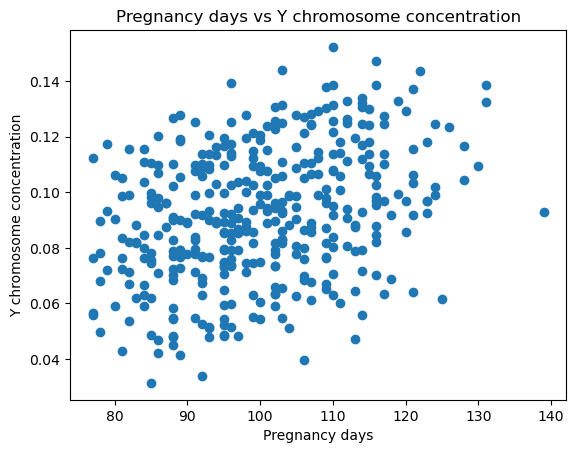

In [341]:
plt.scatter(data["孕天"], data["Y染色体浓度"])
plt.xlabel("Pregnancy days")
plt.ylabel("Y chromosome concentration")
plt.title("Pregnancy days vs Y chromosome concentration")
plt.show()

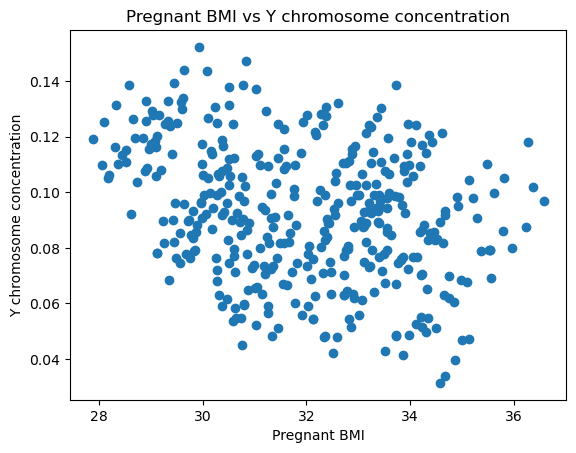

In [342]:
plt.scatter(data["孕妇BMI"], data["Y染色体浓度"])
plt.xlabel("Pregnant BMI")
plt.ylabel("Y chromosome concentration")
plt.title("Pregnant BMI vs Y chromosome concentration")
plt.show()

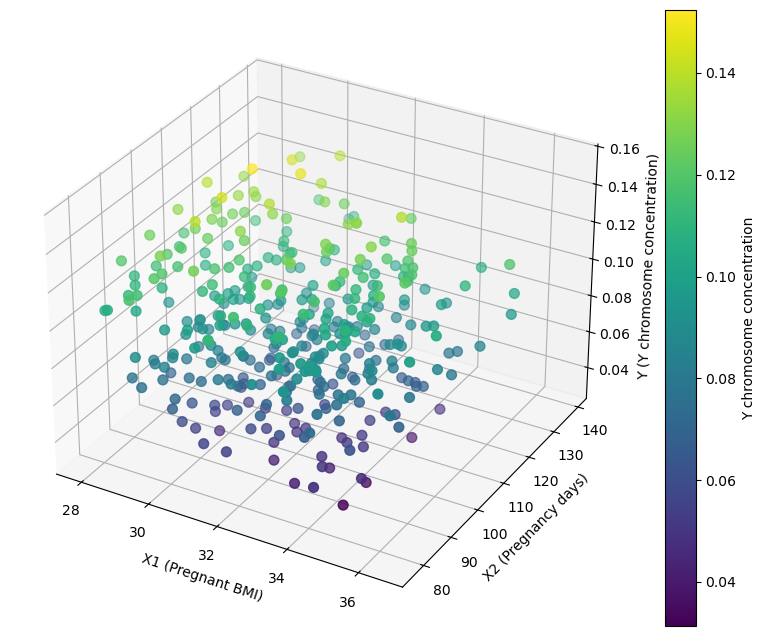

In [343]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 用颜色表现 Y 的大小
sc = ax.scatter(data["孕妇BMI"], data["孕天"], data["Y染色体浓度"], c=data["Y染色体浓度"], cmap="viridis", s=50)

ax.set_xlabel("X1 (Pregnant BMI)")
ax.set_ylabel("X2 (Pregnancy days)")
ax.set_zlabel("Y (Y chromosome concentration)")
plt.colorbar(sc, label="Y chromosome concentration")
plt.show()

In [344]:
Y = data["Y染色体浓度"]
X1 = data["孕妇BMI"]
X2 = np.log(data["孕天"])
print("X1: BMI, X2: log(孕周), Y: Y染色体浓度")

corr, p_value = pearsonr(X1, Y)
corr_spearman, p_value_spearman = spearmanr(X1, Y)
print("X1, Y person r=" , corr , " p=", p_value)
print("X1, Y spearman r=" , corr_spearman , " p=", p_value_spearman)

corr, p_value = pearsonr(X2, Y)
corr_spearman, p_value_spearman = spearmanr(X2, Y)
print("X2, Y r=" , corr , " p=", p_value)
print("X2, Y spearman r=" , corr_spearman , " p=", p_value_spearman)

X1: BMI, X2: log(孕周), Y: Y染色体浓度
X1, Y person r= -0.2969284574870251  p= 2.4463491965786198e-09
X1, Y spearman r= -0.28209633703313586  p= 1.5679133237918774e-08
X2, Y r= 0.3457574744375882  p= 2.4540418639698355e-12
X2, Y spearman r= 0.3365495287233602  p= 9.933730804374506e-12



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
=== GAM模型效果评估 ===
训练集 R²: 0.3568
测试集 R²: 0.2226
训练集 RMSE: 0.0193
测试集 RMSE: 0.0205
训练集 MAE: 0.0156
测试集 MAE: 0.0169

=== GAM模型统计指标 ===
可用的统计属性: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
AIC: 711873.0259
GCV: 0.000461
Pseudo R²: OrderedDict({'explained_deviance': np.float64(0.3567846162767747), 'McFadden': np.float64(0.6418391588738984), 'McFadden_adj': np.float64(0.3581210793069668)})
有效自由度: 22.05
解释方差比例: 0.3568


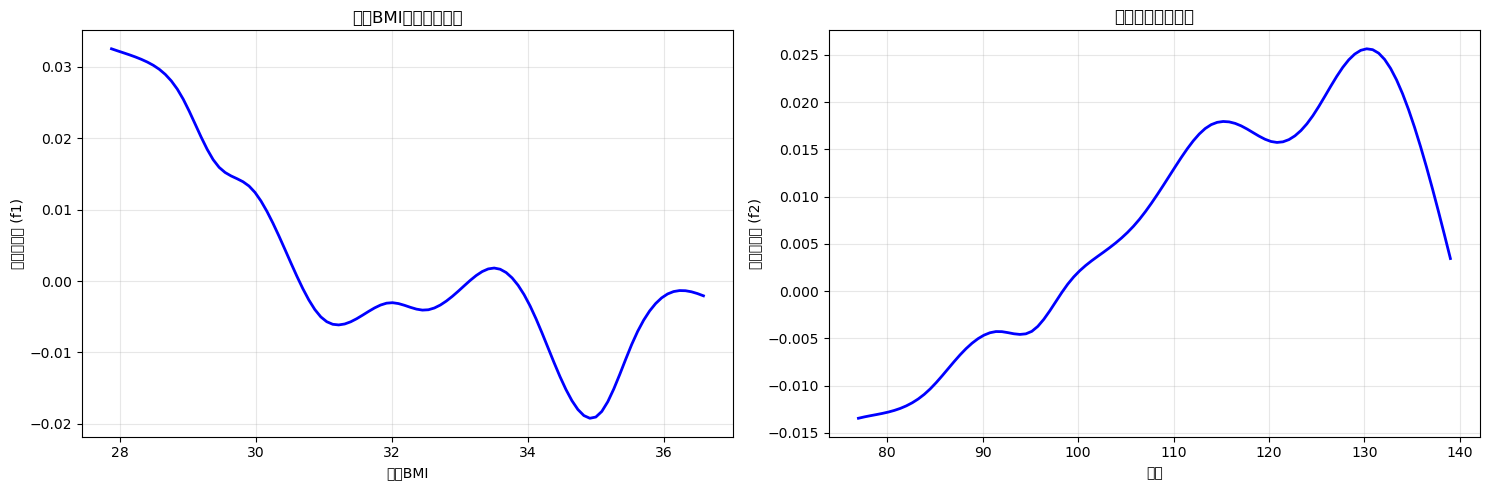

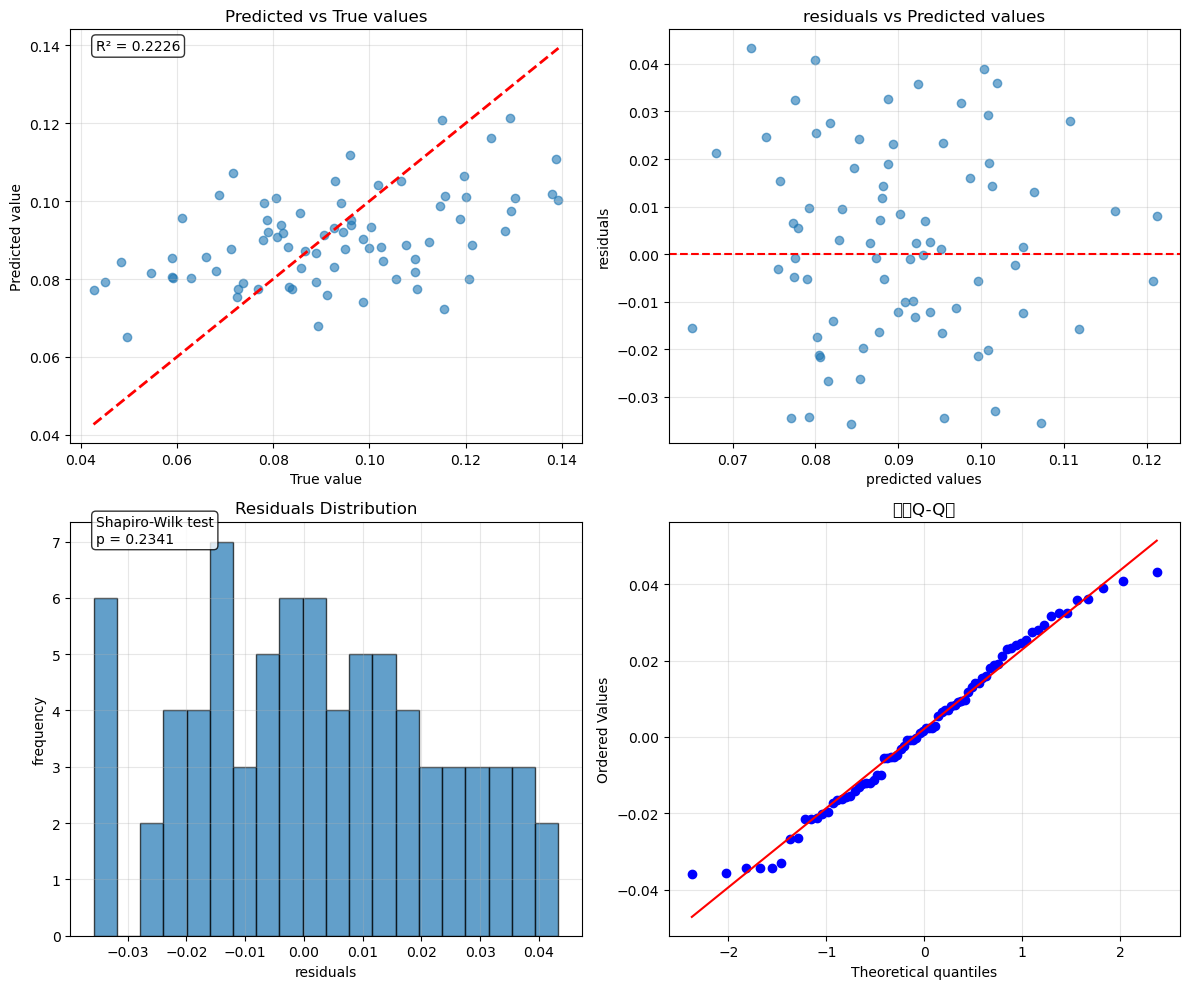


=== 模型显著性检验 ===
F统计量: 85.1448
p值: 1.1102e-16
模型显著 (α=0.05)

=== 残差正态性检验 ===
Shapiro-Wilk统计量: 0.9793
Shapiro-Wilk p值: 0.2341
残差服从正态分布 (α=0.05)

=== 模型总结 ===
• 模型在训练集上的R²为0.3568，在测试集上的R²为0.2226
• 测试集RMSE为0.0205
• 模型整体显著
• 残差服从正态分布假设


In [345]:
!pip install pygam
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# 准备数据
X = data[["孕妇BMI", "孕天"]].values
y = data["Y染色体浓度"].values

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练GAM模型
gam = LinearGAM(s(0) + s(1)).fit(X_train, y_train)

# 预测
y_pred_train = gam.predict(X_train)
y_pred_test = gam.predict(X_test)

print("=== GAM模型效果评估 ===")
print(f"训练集 R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"测试集 R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"训练集 RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"测试集 RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"训练集 MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"测试集 MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

print(f"\n=== GAM模型统计指标 ===")
print("可用的统计属性:", list(gam.statistics_.keys()))

# 安全地获取统计指标
stats = gam.statistics_
if 'AIC' in stats:
    print(f"AIC: {stats['AIC']:.4f}")
if 'GCV' in stats:
    print(f"GCV: {stats['GCV']:.6f}")
if 'pseudo_r2' in stats:
    print(f"Pseudo R²: {stats['pseudo_r2']}")
if 'edof' in stats:
    print(f"有效自由度: {stats['edof']:.2f}")

# 计算解释方差比例
explained_variance_ratio = r2_score(y_train, y_pred_train)
print(f"解释方差比例: {explained_variance_ratio:.4f}")

# 查看每个变量的非线性效果
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
feature_names = ["孕妇BMI", "孕天"]

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep = gam.partial_dependence(term=i, X=XX)
    axes[i].plot(XX[:, i], pdep, 'b-', linewidth=2)
    
    axes[i].set_xlabel(feature_names[i])
    axes[i].set_ylabel(f'偏依赖函数 (f{i+1})')
    axes[i].set_title(f'{feature_names[i]}的非线性效应')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 残差分析
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. 预测值 vs 真实值
axes[0,0].scatter(y_test, y_pred_test, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('True value')
axes[0,0].set_ylabel('Predicted value')
axes[0,0].set_title('Predicted vs True values')
axes[0,0].grid(True, alpha=0.3)

# 计算R²
r2_test = r2_score(y_test, y_pred_test)
axes[0,0].text(0.05, 0.95, f'R² = {r2_test:.4f}', transform=axes[0,0].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. 残差 vs 预测值
residuals = y_test - y_pred_test
axes[0,1].scatter(y_pred_test, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('predicted values')
axes[0,1].set_ylabel('residuals')
axes[0,1].set_title('residuals vs Predicted values')
axes[0,1].grid(True, alpha=0.3)

# 3. 残差分布直方图
axes[1,0].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('residuals')
axes[1,0].set_ylabel('frequency')
axes[1,0].set_title('Residuals Distribution')
axes[1,0].grid(True, alpha=0.3)

# 添加正态性统计
from scipy.stats import shapiro
shapiro_stat, shapiro_p = shapiro(residuals)
axes[1,0].text(0.05, 0.95, f'Shapiro-Wilk test\np = {shapiro_p:.4f}', 
               transform=axes[1,0].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Q-Q图
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('残差Q-Q图')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 模型显著性检验
print(f"\n=== 模型显著性检验 ===")
n = len(y_train)
k = 2  # 两个变量
ss_res = np.sum((y_train - y_pred_train)**2)
ss_tot = np.sum((y_train - np.mean(y_train))**2)
ss_reg = ss_tot - ss_res

mse_reg = ss_reg / k
mse_res = ss_res / (n - k - 1)
f_stat = mse_reg / mse_res

from scipy.stats import f
p_value = 1 - f.cdf(f_stat, k, n - k - 1)

print(f"F统计量: {f_stat:.4f}")
print(f"p值: {p_value:.4e}")
print(f"模型{'显著' if p_value < 0.05 else '不显著'} (α=0.05)")

# 残差正态性检验
print(f"\n=== 残差正态性检验 ===")
print(f"Shapiro-Wilk统计量: {shapiro_stat:.4f}")
print(f"Shapiro-Wilk p值: {shapiro_p:.4f}")
print(f"残差{'服从' if shapiro_p > 0.05 else '不服从'}正态分布 (α=0.05)")

print(f"\n=== 模型总结 ===")
print(f"• 模型在训练集上的R²为{r2_score(y_train, y_pred_train):.4f}，在测试集上的R²为{r2_score(y_test, y_pred_test):.4f}")
print(f"• 测试集RMSE为{np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"• 模型整体{'显著' if p_value < 0.05 else '不显著'}")
print(f"• 残差{'服从' if shapiro_p > 0.05 else '不服从'}正态分布假设")

                            OLS Regression Results                            
Dep. Variable:                 Y染色体浓度   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     63.59
Date:                Fri, 05 Sep 2025   Prob (F-statistic):           1.37e-24
Time:                        00:39:34   Log-Likelihood:                 953.06
No. Observations:                 388   AIC:                            -1900.
Df Residuals:                     385   BIC:                            -1888.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1330      0.042     -3.193      0.0

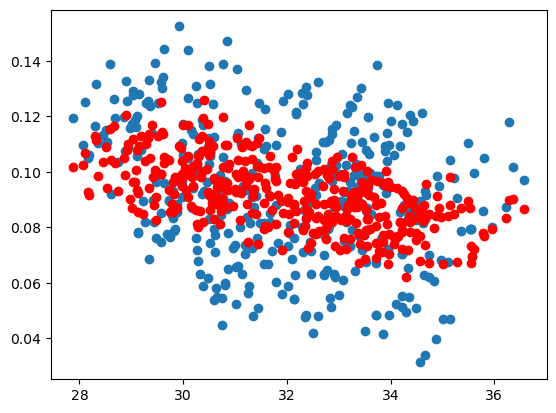

In [346]:
import statsmodels.api as sm

# 假设 df 是你的数据框，y是因变量，X是自变量列表
data["log孕天"] = np.log(data["孕天"])
X = data[['孕妇BMI', 'log孕天']]
y = data['Y染色体浓度']

# 添加截距项
X = sm.add_constant(X)

# 拟合OLS模型
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())

plt.scatter(data["孕妇BMI"], data["Y染色体浓度"])
plt.scatter(data["孕妇BMI"], model.predict(X), color='red')